In [1]:
import sys
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/')

from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from scannotation_aux import ASAPP
from data._dataloader import DataSet
from util import _topics


import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from data import _sim 
from scipy import stats
from sklearn.metrics import mean_squared_error as mse

import joblib

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet()
dl.config = args
dl.initialize_path()
print(dl.inpath)
print(dl.outpath)

## for sim data
N = 1000
K = 10
P = 2000
X = pd.read_csv(dl.inpath+'_X.csv.gz')


dl.mtx = np.asmatrix(X)
dl.rows = ['c_'+str(i) for i in range(N) ]
dl.cols = ['g_'+str(i) for i in range(P) ]

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


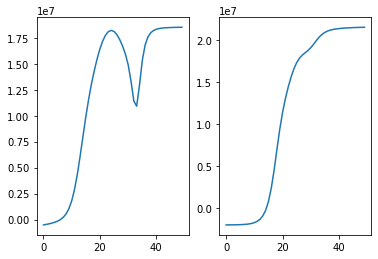

In [2]:
asap = ASAPP(adata=dl,tree_min_leaf=1, tree_max_depth=10,factorization='VB', max_iter=50)
asap.factorize()
asap.predict(dl.mtx)

asapsc = ASAPP(adata=dl,generate_pbulk=False,max_iter=50,factorization='VB')
asapsc.factorize()
asapsc.predict(dl.mtx)

figure,axis = plt.subplots(1,2)
axis[0].plot(asap.model.bound)
axis[1].plot(asapsc.model.bound)

In [3]:
import umap
df_sctheta = pd.DataFrame(asap.model.Etheta)
df_btheta = pd.DataFrame(asapsc.model.Etheta)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_sc'] = [x for x in df_sctheta.iloc[:,1:].idxmax(axis=1)]
df_umap['topic_bulk'] = [x for x in df_btheta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_sctheta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_sc,topic_bulk,umap1,umap2
0,c_0,4,3,4.184296,-0.573244
1,c_1,5,3,6.627132,7.107955
2,c_2,7,3,9.342462,4.090255
3,c_3,2,3,0.961394,6.661053
4,c_4,1,3,4.914096,11.931545
...,...,...,...,...,...
995,c_995,4,2,3.685456,0.243528
996,c_996,3,8,6.012775,12.915285
997,c_997,2,7,1.062393,5.734936
998,c_998,4,3,4.379309,0.371568


Text(0, 0.5, 'UMAP2')

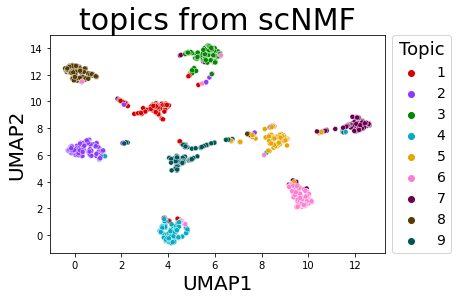

In [4]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_sc'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_sc',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from scNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

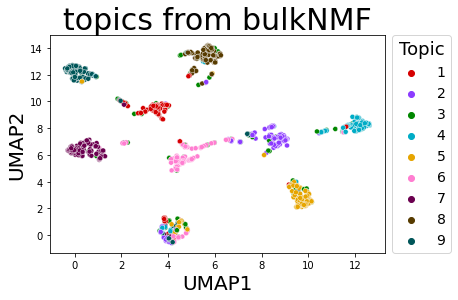

In [5]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(218.45454545454544, 0.5, 'bulk')

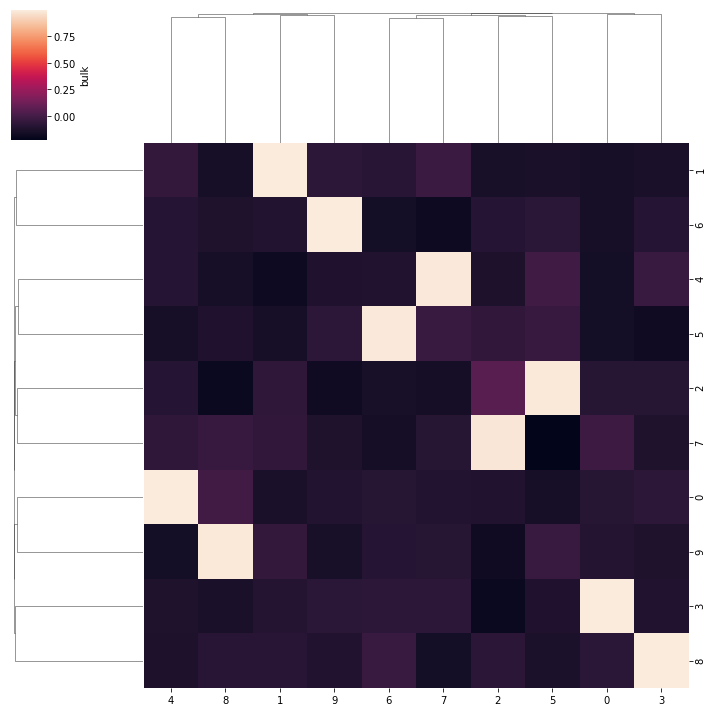

In [6]:
df_scbeta = pd.DataFrame(asap.model.Ebeta)
df_bbeta = pd.DataFrame(asapsc.model.Ebeta)


sel_top_genes = list(np.unique(_topics.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.loc[i,sel_top_genes],df_scbeta.loc[j,sel_top_genes])[0,1])
    corr.append(cr)
sns.clustermap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


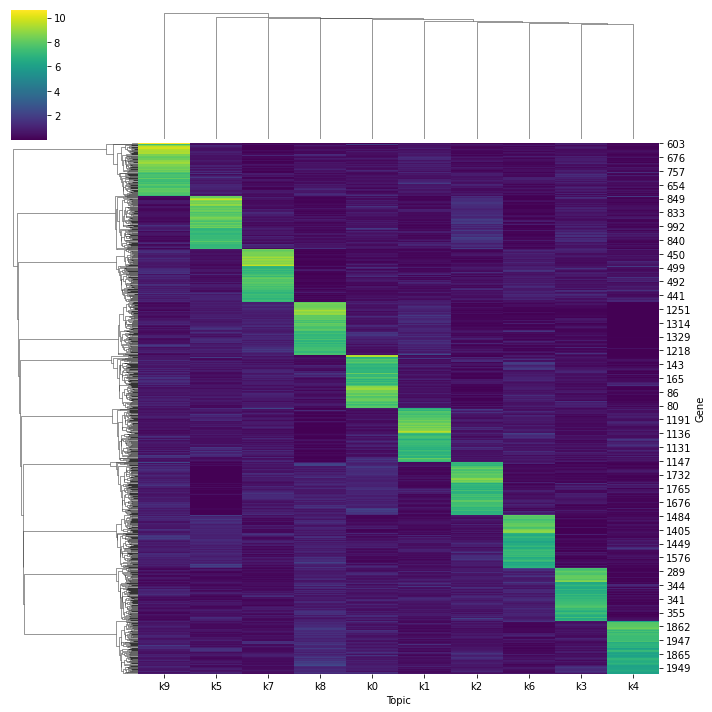

In [7]:
df_top = _topics.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')



/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


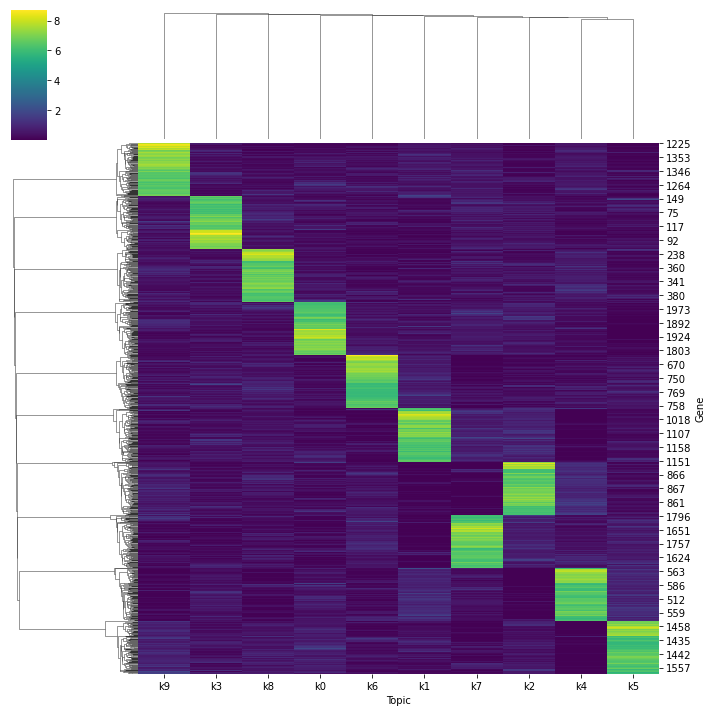

In [8]:
df_top = _topics.get_topic_top_genes(df_bbeta.iloc[:,1:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')